In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Sustainable resource allocation in complex networks

In this experiment we are investigating the usefulness of the concept of graph energy for devising an initial allocation of resources to vertices in a complex network. Vertices exchange resources along edges, and our goal is to find the initial allocation which will minimize the overall ineqality of allocation of the resource.

### Measures of allocation inequality

There are two measures for the inequality of allocation. Let us assume a network $G=\left<V,E\right>$ with the set of vertices $V=\{ v_1, \ldots, v_n\}$ and the set of edges $E=\{ (v_i, v_j): v_i, v_j \in V \}$. Let $R=\left[r_1, \ldots, r_n\right]$ be the allocation of a resource to vertices such that $\sum_{i=1}^n r_i=1$. We use the gini coefficient to measure the inequality of resource allocation:

- gini coefficient: $gini(R) = \frac{\sum_{i=1}^n\sum_{j=1}^n\left|r_i-r_j\right|}{2n\sum_{i=1}^n r_i}$

We have also experimented with entropy, but it had to be discretized (which introduces a new parameter - the number of bins) and produced discrete sequences which were not informative.

We measure the inequality of two independent allocations:

- vertex allocation: we look at the allocation of resource for each individial vertex
- egocentric allocation: we look at the sum of resources for each egocentric network of radius 1

### Graph energies

Graph energy of a graph is defined as $E_G(G) = \sum\limits_{i=1}^n |\mu_i|$, where $\mu_1, \ldots, \mu_n$ are the eigenvalues of the adjacency matrix $M_A$ (also known as the *spectrum* of the graph).

Randić matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_R(i,j)=
\begin{cases}
0 & \mathit{if} & i=j\\
\frac{1}{\sqrt{d_i d_j}} & \mathit{if} & (i,j) \in E\\
0 & \mathit{if} & (i,j) \notin E
\end{cases}
$$

Randić energy of a graph is defined as $E_R(G) = \sum\limits_{i=1}^n |\rho_i|$, where $\rho_1, \ldots, \rho_n$ are the eigenvalues of the Randić matrix $M_R$.

### Allocation schemes

In our experiments we use the following allocation mechanisms:

- **random**: each vertex receives a random initial allocation (drawn from the normal distribution)
- **constant**: each vertex receives the same initial allocation
- **pagerank**: each vertex receives initial allocation based on its pagerank centrality
- **randic**: each vertex receives initial allocation based on the Randic energy of its egocentric network
- **graph**: each vertex receives initial allocation based on the graph energy of its egocentric network

After allocating the resource $R$ we normalize the overall allocation so that $\sum_{i=1}^n r_i=1$.

### Experimental protocol

The outline of the experiment is as follows. We take a network and allocate the resource to each vertex of the network. Then we run $k$ iterations, where during each iteration every vertex sends a small amount of the resource to one of its neighbours (if the vertex has enough resource to send). After each iteration we measure the change in resource allocation, in particular, we measure the inequality of resource allocation in the network using gini coefficient and entropy.

Possible extensions of the basic experimental framework include the following directions:

- each vertex randomly decides if it wants to exchange resources during the current iteration
- the amount of resource being exchanged is drawn randomly from some distribution (instead of being constant)
- vertices select neighbors to send resources to using preferential attachment and target vertex degree

In [27]:
import networkx as nx
import numpy as np
import pandas as pd

import sys
sys.path.append('../..')

from networkentropy import network_energy as ne
from tqdm import tqdm

tqdm.monitor_interval = 0

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [5]:
# a small helper function to flatten a list of lists
flatten = lambda lst: [x for sublst in lst for x in sublst]

In [6]:
# two helper functions to calculate the Randić energy and the graph energy of an egocentric network 
# with a given radius.

def calculate_randic_energy(graph, radius=1):
    results = { n: ne.get_randic_energy(nx.ego_graph(G=graph, n=n, radius=radius)) for n in graph.nodes }
    return results


def calculate_graph_energy(graph, radius=1):
    results = { n: ne.get_graph_energy(nx.ego_graph(G=graph, n=n, radius=radius)) for n in graph.nodes }
    return results

### First experiment: resource allocation in a random network (Erdos-Renyi model)

In the first experiment we use an artificial network generated from the Erdos-Renyi random network model.

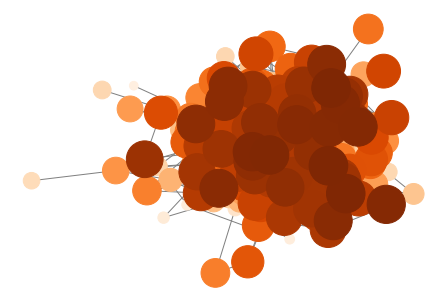

In [7]:
# the following shows our random graph with the color and size of vertices 
# proportional to the graph energy of each vertex egocentric network 

g = nx.erdos_renyi_graph(n=300, p=0.025)
g.graph['name'] = 'erdos-renyi'

ge = calculate_graph_energy(g)

options = { 
    'node_color': [d * 1 for d in list(ge)], 
    'node_size': [d * 5 for d in list(ge)], 
    'cmap': plt.cm.Oranges,
    'edge_color': 'gray' 
}

nx.draw(g, **options)

In [8]:
# there are two implementations of the gini coefficient computation to make sure that there is no error
# in the actual computation. both implementations return very similar estimations up to 1E-16

def gini(X):
    '''
    Compute the Gini coefficient of a distribution
    
    Args:
        X: array-like distribution
        
    Tests:
    >>> gini([0, 0, 0, 1, 1, 1])
    0.5
    >>> gini([1, 1, 1, 1, 1, 1])
    0.0
    >>> gini([1, 1, 1, 1])
    0.0
    >>> gini([0, 0,  0, 1])
    0.75
    >>> gini([0, 0,  1, 1])
    0.5
    '''
    
    X = np.array(X)
    
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(X, X)).mean()
    
    # Relative mean absolute difference
    rmad = mad/np.mean(X)
    
    # Gini coefficient
    g = 0.5 * rmad
    
    return g

In [9]:
def gini2(x, w=None):
    '''
    Compute the Gini coefficient of the distribution
    
    Tests:
    >>> round(gini2([0, 0, 0, 1, 1, 1]), 2)
    0.5
    >>> round(gini2([1, 1, 1, 1, 1, 1]), 2)
    0.0
    >>> round(gini2([0, 0, 0, 0, 1, 1]), 2)
    0.67
    >>> round(gini2([0, 0, 0, 0, 0, 1]), 2)
    0.83
    '''
    
    
    # Array indexing requires reset indexes.
    x = pd.Series(x).reset_index(drop=True)
    
    if w is None:
        w = np.ones_like(x)
    
    w = pd.Series(w).reset_index(drop=True)
    n = x.size
    wxsum = sum(w * x)
    wsum = sum(w)
    sxw = np.argsort(x)
    sx = x[sxw] * w[sxw]
    sw = w[sxw]
    pxi = np.cumsum(sx) / wxsum
    pci = np.cumsum(sw) / wsum
    g = 0.0
    
    for i in np.arange(1, n):
        g = g + pxi.iloc[i] * pci.iloc[i - 1] - pci.iloc[i] * pxi.iloc[i - 1]
    return g

In [10]:
def entropy(X):
    '''
    Compute the entropy of a distribution
    
    Args:
        X: array-like distribution
        
    Tests:
    >>> entropy([0, 0, 0, 0])
    -0.0
    >>> entropy([0, 0, 0, 1, 1, 1])
    1.0
    '''
    
    prob_dict = { x:X.count(x)/len(X) for x in X}
    probs = np.array(list(prob_dict.values()))

    return -probs.dot(np.log2(probs))

In [11]:
def normalize_dict(dictionary, target=1.0):
    '''
    Normalizes the values in the dictionary so that they sum up to factor
    
    Args: 
        dictionary: dict to be normalized
        factor: value to which all values in the dictionary should sum up to
    
    Tests:
    >>> normalize_dict({0: 10, 1: 30})
    {0: 0.25, 1: 0.75}
    '''
    raw = sum(dictionary.values())
    factor = target/raw
   
    return { key: value*factor for key,value in dictionary.items() }

In [12]:
def histogram(lst):
    '''
    Computes the histogram of values provided as a list and returns normalized frequency counts
    
    Args:
        lst: input list of values
    
    Tests:
    >>> histogram([0,0,0,1,1,1])
    [0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]
    '''
    
    hist, hist_thresholds = np.histogram(lst, density=True)
    
    return list(hist*np.diff(hist_thresholds))

In [13]:
import doctest
doctest.testmod()

TestResults(failed=0, attempted=13)

In [14]:
# assign some arbitrary resource to all nodes

def initial_allocation(g, budget, allocations):
    '''
    Performs an initial allocation of a given budget of a resource to all vertices of a given network, using provided allocation schemes
    
    Args:
        g: graph to be annotated
        budget: summary budget of allocation
        allocations: list of allocation schemes
        
    Returns:
        graph g with node attributes representing allocations
    '''

    r_random = normalize_dict({ node: np.random.random() for node in g.nodes }, target=budget)
    r_constant = normalize_dict({ node:1 for node in g.nodes }, target=budget)
    r_pagerank = normalize_dict(nx.pagerank(g), target=budget)
    r_randic = normalize_dict(calculate_randic_energy(g), target=budget)
    r_graph = normalize_dict(calculate_graph_energy(g), target=budget)

    nx.set_node_attributes(g, r_random, 'random')
    nx.set_node_attributes(g, r_constant, 'constant')
    nx.set_node_attributes(g, r_pagerank, 'pagerank')
    nx.set_node_attributes(g, r_randic, 'randic')
    nx.set_node_attributes(g, r_graph, 'graph')

    return g

In [15]:
# definition of a single iteration where each vertex sends resources to a randomly chosen neighbor

def do_turn(graph, allocations):
    '''
    Performs a single iteration of resource exchange
    
    Args:
        graph: input graph
        allocations: list of names of attributes which hold the initial allocation
    '''
    for node in graph.nodes:
        neighbors = nx.ego_graph(graph, node, radius=1).nodes
        
        # select a neighbor to trade resources with
        neighbor = np.random.choice(neighbors)

        # select amount to trade
        amount = 0.001

        for allocation in allocations:

            if graph.nodes[node][allocation] > amount:
                graph.nodes[node][allocation] -= amount
                graph.nodes[neighbor][allocation] += amount
                
    return

In [17]:
def run_network(g, budget, allocations, num_iterations):
    '''
    Creates initial allocation and simulates the flow of resources within the network
    
    Args:
        g: input graph
        budget: initial amount of resource to be distributed
        allocations: list of names of attributes which hold the initial allocation
        num_iterations: number of iterations of resource exchange
        
    '''

    result = []

    # helper function which computes the sum of resource allocation 
    # for a given vertex' egocentric network
    sum_ego_graph_resource = lambda g, node, resource, radius: sum([g.nodes[n][resource] for n in nx.ego_graph(g, node, radius=radius).nodes])

    graph_name = g.graph['name']
    
    # select the greatest connected component of a network
    g = max(nx.connected_component_subgraphs(g), key=len)
    
    g = initial_allocation(g, budget=budget, allocations=allocations)
    
    for i in tqdm(range(num_iterations)):
        do_turn(g, allocations)

        for allocation in allocations:

            vertex_resource_distribution = list(nx.get_node_attributes(g, allocation).values())
            egonet_resource_distribution = [sum_ego_graph_resource(g, n, allocation, 1) for n in g.nodes]

            result.append((graph_name, i, allocation, 'vertex distribution', gini(vertex_resource_distribution)))
            result.append((graph_name, i, allocation, 'egonet distribution', gini(egonet_resource_distribution)))

    return result

In [18]:
budget = 1
allocations = ['random','constant', 'pagerank', 'randic', 'graph']
num_iterations = 1000

results = []

results = run_network(g, budget, allocations, num_iterations)

df = pd.DataFrame(results, columns=['network','iteration','allocation','inequality level', 'inequality'])
df = df.melt(id_vars=['network','iteration','inequality level','allocation'], value_vars=['inequality'])

df.to_csv('inequality_erdos_results.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:48<00:00,  2.21it/s]


First, let us take a look on the change of resource allocation inequality across individual vertices. As it turns out, for every allocation scheme the inequality increases until a stable plateau is reached. 

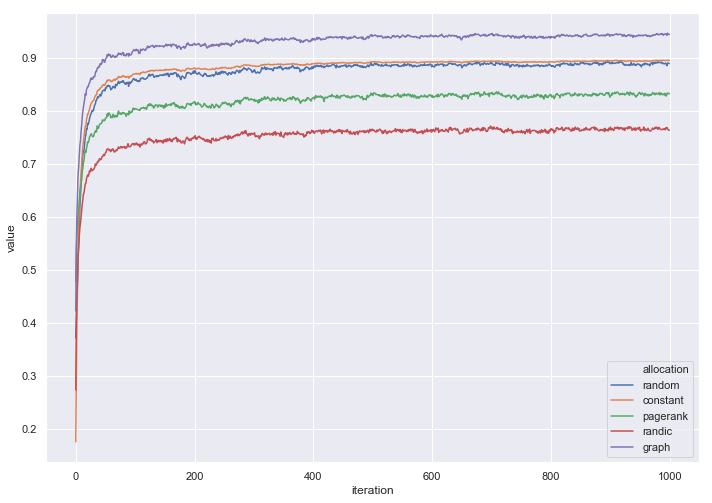

In [28]:
# gini inequality for vertex inequality
distribution_idx = df['inequality level'] == 'vertex distribution'

sns.lineplot(data=df[distribution_idx], x='iteration', y='value', hue='allocation')

Interestingly, the change in allocation inequality looks totally different when measured at the level of egocentric networks.

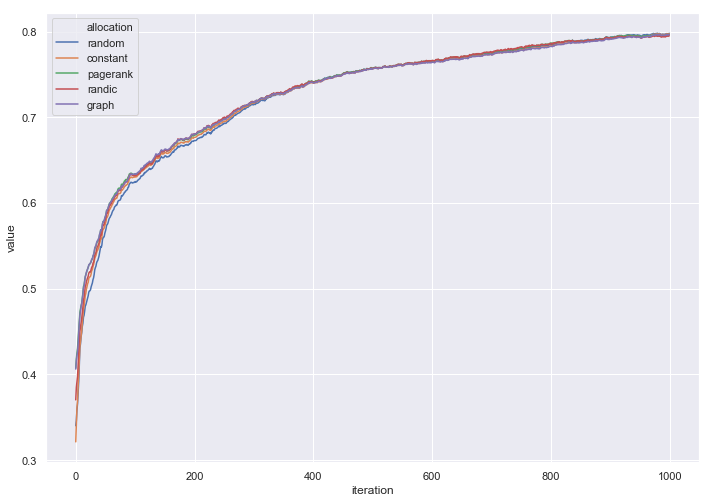

In [29]:
# gini inequality for egocentric networks
distribution_idx = df['inequality level'] == 'egonet distribution'

sns.lineplot(data=df[distribution_idx], x='iteration', y='value', hue='allocation')

Let's take a closer look at the last iterations. It turns out, that when initial allocation was made accordingly to graph/randić energy, this allocation leads to the least unequal final allocation.

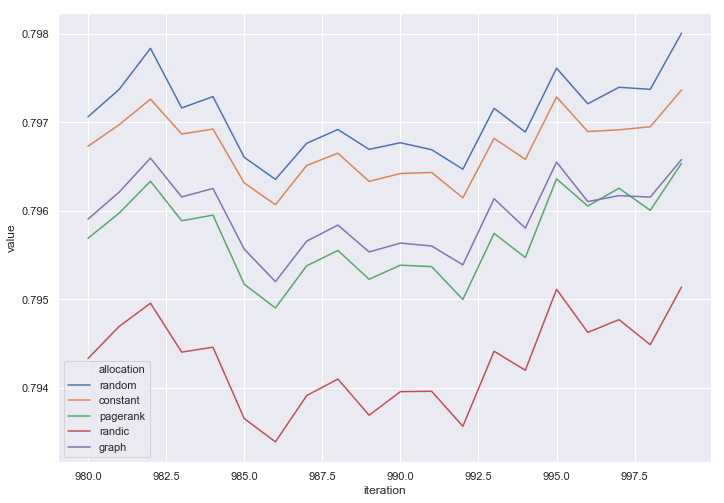

In [30]:
sns.lineplot(data=df[distribution_idx][-100:], x='iteration', y='value', hue='allocation')

## Second experiment: Resource allocation in a scale free network (Holme-Kim model)

Let us repeat the above experiment, but this time using a scale free network as the topology for resource exchange. Holme-Kim is basically the same as Albert-Barabasi model, the only difference is that after creating an edge, with some probability the vertex tries to add one more triad-closing edge. As the result, the Holme-Kim model produces powerlaw distributions of in- and out-degrees, but produces slightly higher average clustering coefficients.

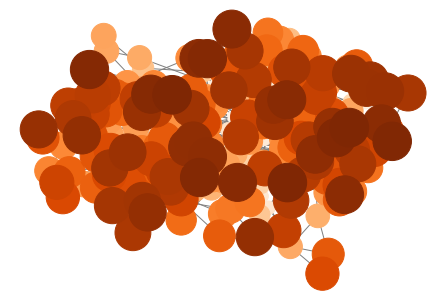

In [22]:
# the following shows our random graph with the color and size of vertices 
# proportional to the graph energy of each vertex egocentric network 

g = nx.powerlaw_cluster_graph(n=300, m=2, p=0.1)
g.graph['name'] = 'holme-kim'

ge = calculate_graph_energy(g)

options = { 
    'node_color': [d * 1 for d in list(ge)], 
    'node_size': [d * 5 for d in list(ge)], 
    'cmap': plt.cm.Oranges,
    'edge_color': 'gray' 
}

nx.draw(g, **options)

In [23]:
budget = 1
allocations = ['random','constant', 'pagerank', 'randic', 'graph']
num_iterations = 1000

results = []

results = run_network(g, budget, allocations, num_iterations)

df = pd.DataFrame(results, columns=['network','iteration','allocation','inequality level', 'inequality'])
df = df.melt(id_vars=['network','iteration','inequality level','allocation'], value_vars=['inequality'])

df.to_csv('inequality_holme-kim_results.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:16<00:00,  3.65it/s]


Again, let us analyze the change of inequality of resource allocation for individual vertices

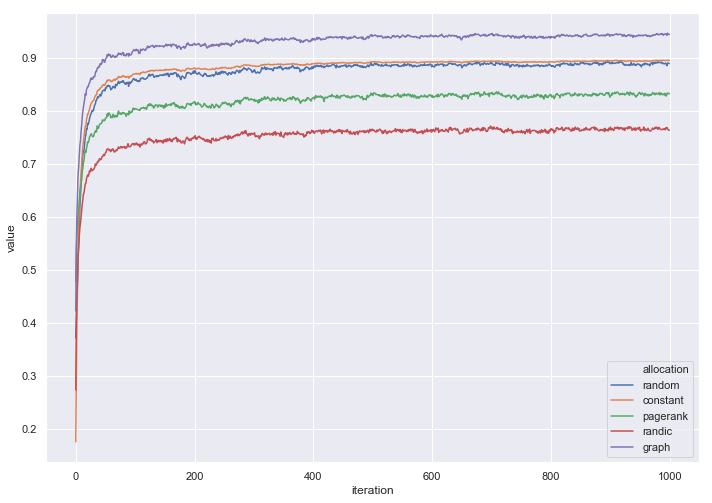

In [31]:
# gini inequality for vertex inequality
distribution_idx = df['inequality level'] == 'vertex distribution'

sns.lineplot(data=df[distribution_idx], x='iteration', y='value', hue='allocation')

And the same change when measuring the inequality of allocation across egocentric networks

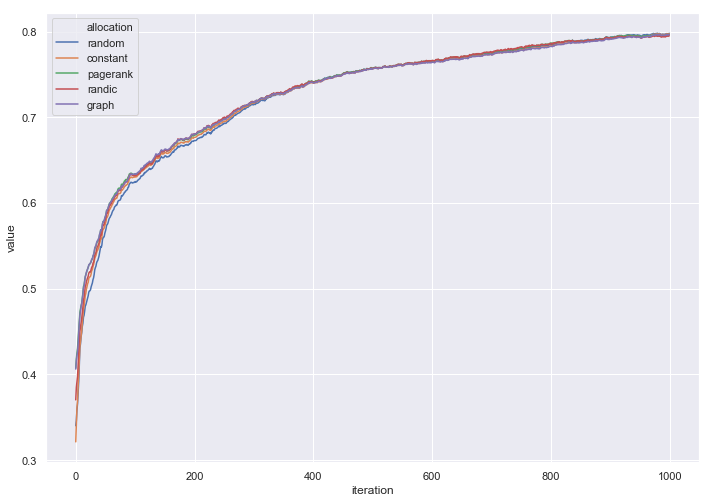

In [32]:
# gini inequality for egocentric networks
distribution_idx = df['inequality level'] == 'egonet distribution'

sns.lineplot(data=df[distribution_idx], x='iteration', y='value', hue='allocation')

We see again that initial allocation according to graph/randić energy leads to the least unequal final allocation.

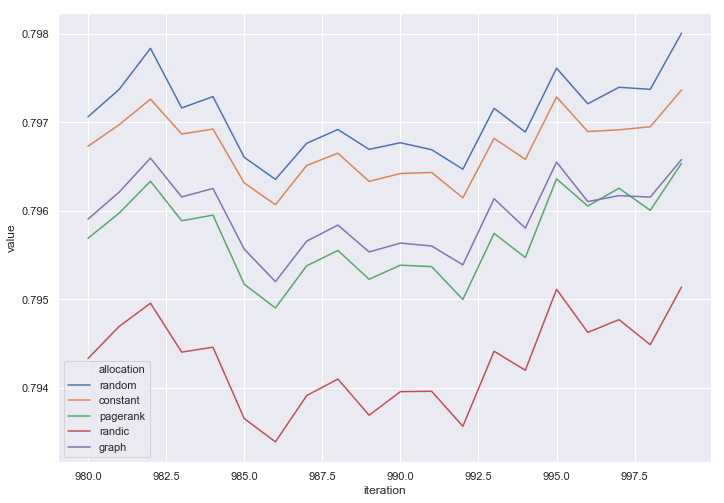

In [33]:
# gini inequality for egocentric networks
distribution_idx = df['inequality level'] == 'egonet distribution'

sns.lineplot(data=df[distribution_idx][-100:], x='iteration', y='value', hue='allocation')

## Third experiment: resource allocation in empirical networks

In this experiment we take several empirical networks from the Konect network repository and we repeat the same experiment, this time using real-world topologies. To save time we experiment with small networks (with less than 1000 vertices). The experimental protocol is identical as above.

In [412]:
from bs4 import BeautifulSoup
import requests
import wget
import tarfile
import os
import shutil
import time

In [413]:
def read_avalilable_datasets_konect():
    base_url = "http://konect.uni-koblenz.de/downloads/"
    response = requests.get(base_url)
    
    if response.status_code != 200:
        print("An error occurred while getting data.")
    else:
        html = response.content
        soup = BeautifulSoup(html, "html5lib")
        
        table_html = soup.find(id='sort1')
        
        thead_html = table_html.find('thead')
        tbody_html = table_html.find('tbody')
         
        column_names=[row.text for row in thead_html.findAll('td')]
        rows = tbody_html.findAll('tr')
        values=[[cell.get('href') for cell in value('a') if 'tsv' in cell.get('href')] for value in rows]
        return [val[0].replace('.tar.bz2','').replace('tsv/','') for val in values]
        
def download_tsv_dataset_konect(network_name):
    assert (network_name in read_avalilable_datasets_konect()),"No network named: '"+network_name+"' found in Konect!"
    
    tsv_file = 'http://konect.uni-koblenz.de/downloads/tsv/'+network_name+'.tar.bz2'
    output_file=network_name+'.tar.bz2'
    file_name = wget.download(tsv_file, out=output_file)
    if os.path.exists(output_file):
        shutil.move(file_name,output_file)
    
    return output_file
    
def unpack_tar_bz2_file(file_name):
    tar = tarfile.open("./"+file_name, "r:bz2")
    output_dir="./network_"+file_name.replace('.tar.bz2','')+"/"
    tar.extractall(output_dir)
    tar.close()
    return output_dir

def build_network_from_out_konect(network_name):
    file_name=download_tsv_dataset_konect(network_name=network_name)
    output_dir=unpack_tar_bz2_file(file_name)+network_name+"/"
    files = [file for file in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, file))]
    out_file = [file for file in files if 'out.' in file]
    assert (len(out_file)>0), 'No out. file in the directory.'
    
    #building network
    G=nx.read_adjlist(output_dir+out_file[0], comments='%')
    
    return G

In [ ]:
network_names = [
 'moreno_beach',
 'moreno_bison',
 'moreno_blogs',
 'moreno_cattle',
 'moreno_crime',
 'moreno_health',
 'moreno_hens',
 'moreno_highschool',
 'moreno_innovation',
 'moreno_kangaroo',
 'moreno_lesmis',
 'moreno_mac',
 'moreno_names',
 'moreno_oz',
 'moreno_propro',
 'moreno_rhesus',
 'moreno_sampson',
 'moreno_seventh',
 'moreno_sheep',
 'moreno_taro',
 'moreno_train',
 'moreno_vdb',
 'moreno_zebra',
 'brunson_club-membership',
 'brunson_southern-women',
 'brunson_corporate-leadership',
 'brunson_revolution',
 'brunson_south-africa',
 'ucidata-gama',
 'ucidata-zachary',
 'opsahl-collaboration',
 'opsahl-openflights',
 'opsahl-powergrid',
 'opsahl-southernwomen',
 'opsahl-ucforum',
 'opsahl-ucsocial',
 'opsahl-usairport',
 'contiguous-usa',
 'dolphins',
 'adjnoun_adjacency',
 'mit',
 'foodweb-baydry',
 'foodweb-baywet',
 'sociopatterns-hypertext',
 'sociopatterns-infectious',
 'radoslaw_email'
]

In [ ]:
networks = []

for network_name in tqdm(network_names):
    networks.append(build_network_from_out_konect(network_name))

In [363]:
budget = 1
allocations = ['random','constant', 'pagerank', 'randic', 'graph']
num_iterations = 1000
small_network_threshold = 1000

results = []

small_networks = [(network_name, network) for (network_name, network) in zip(networks_names, networks) if network.number_of_nodes() < small_network_threshold]

for (network_name, network) in small_networks:
    network.graph['name'] = network_name
    results.append(run_network(network, budget, allocations, num_iterations))

results = flatten(results)

  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_beach


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_bison


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_cattle


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_crime


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_hens


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_highschool


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_innovation


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_kangaroo


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_lesmis


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_mac


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_oz


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_rhesus


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_sampson


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_seventh


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_sheep


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_taro


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_train


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_vdb


  0%|          | 0/1000 [00:00<?, ?it/s]

***  moreno_zebra


  0%|          | 0/1000 [00:00<?, ?it/s]

***  brunson_club-membership


  0%|          | 0/1000 [00:00<?, ?it/s]

***  brunson_southern-women


  0%|          | 0/1000 [00:00<?, ?it/s]

***  brunson_corporate-leadership


  0%|          | 0/1000 [00:00<?, ?it/s]

***  brunson_revolution


  0%|          | 0/1000 [00:00<?, ?it/s]

***  brunson_south-africa


  0%|          | 0/1000 [00:00<?, ?it/s]

***  ucidata-gama


  0%|          | 0/1000 [00:00<?, ?it/s]

***  ucidata-zachary


  0%|          | 0/1000 [00:00<?, ?it/s]

***  opsahl-southernwomen


  0%|          | 0/1000 [00:00<?, ?it/s]

***  contiguous-usa


  0%|          | 0/1000 [00:00<?, ?it/s]

***  dolphins


  0%|          | 0/1000 [00:00<?, ?it/s]

***  adjnoun_adjacency


100%|██████████| 1000/1000 [03:43<00:00,  4.47it/s]


In [365]:
df = pd.DataFrame(results, columns=['network','iteration','allocation','inequality level', 'inequality'])
df = df.melt(id_vars=['network','iteration','inequality level','allocation'], value_vars=['inequality'])

df.to_csv('inequality_results.csv', index=False)

#### Inequality of vertex resource allocation

As expected, when considering the inequality of allocation to individual vertices, the best results can be obtained by either random or constant allocation (each vertex receives exactly the same initial allocation). The table below presents, for each network, the initial allocation producing the lowest gini coefficient (column _value_) during the last iteration. 

In [366]:
# gini inequality for individual vertices
distribution_idx = df['inequality level'] == 'vertex distribution'

# here we find the best initial allocation when the inequality between individual vertices is of interest
dfm = df[(df['iteration'] == 999) & distribution_idx]
idx = dfm.groupby(['network'])['value'].transform(min) == dfm['value']
dfm[idx]

,network,iteration,inequality level,allocation,variable,value
9990,moreno_beach,999,vertex distribution,random,inequality,0.817029
19992,moreno_bison,999,vertex distribution,constant,inequality,0.812138
29996,moreno_cattle,999,vertex distribution,randic,inequality,0.825201
39992,moreno_crime,999,vertex distribution,constant,inequality,0.813586
49990,moreno_hens,999,vertex distribution,random,inequality,0.810995
59992,moreno_highschool,999,vertex distribution,constant,inequality,0.813448
69990,moreno_innovation,999,vertex distribution,random,inequality,0.817133
79990,moreno_kangaroo,999,vertex distribution,random,inequality,0.786507
89996,moreno_lesmis,999,vertex distribution,randic,inequality,0.813248
99998,moreno_mac,999,vertex distribution,graph,inequality,0.824380


#### Inequality of egocentric network resource allocation

Interestingly, the result is quite differnet when we are interested in having the least inequality between egocentric networks (i.e. small communities). Here, the best initial allocation is usually graph or randić allocation, with a few exceptions. Also, the gini coefficient is much smaller (0.01-0.02) than for the inequality of individual vertices (0.77-0.82)

In [367]:
# gini inequality for individual vertices
distribution_idx = df['inequality level'] == 'egonet distribution'

# here we find the best initial allocation when the inequality between egocentric networks is concerned
dfm = df[(df['iteration'] == 999) & distribution_idx]
idx = dfm.groupby(['network'])['value'].transform(min) == dfm['value']
dfm[idx]

,network,iteration,inequality level,allocation,variable,value
9993,moreno_beach,999,egonet distribution,constant,inequality,0.018505
19991,moreno_bison,999,egonet distribution,random,inequality,0.020266
29999,moreno_cattle,999,egonet distribution,graph,inequality,0.016633
39999,moreno_crime,999,egonet distribution,graph,inequality,0.021786
49999,moreno_hens,999,egonet distribution,graph,inequality,0.018365
59991,moreno_highschool,999,egonet distribution,random,inequality,0.019568
69997,moreno_innovation,999,egonet distribution,randic,inequality,0.018854
79997,moreno_kangaroo,999,egonet distribution,randic,inequality,0.024997
89993,moreno_lesmis,999,egonet distribution,constant,inequality,0.021605
99997,moreno_mac,999,egonet distribution,randic,inequality,0.018854


Below we randomly pick one of the empirical networks to plot the change of inequality of allocation for individual vertices and egocentric networks. We see exactly the same pattern as in the case of a random network and a scale-free network.

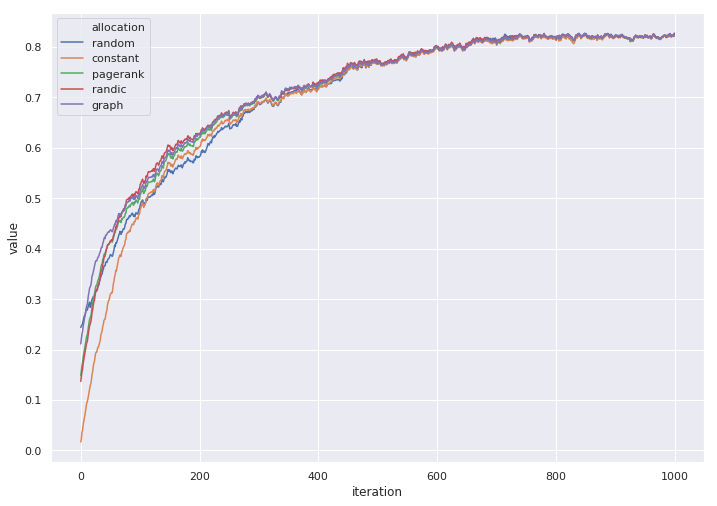

In [374]:
# gini inequality for vertex inequality
distribution_idx = df['inequality level'] == 'vertex distribution'
nietwork_idx = df['network'] == 'brunson_revolution'

sns.lineplot(data=df[distribution_idx & network_idx], x='iteration', y='value', hue='allocation')

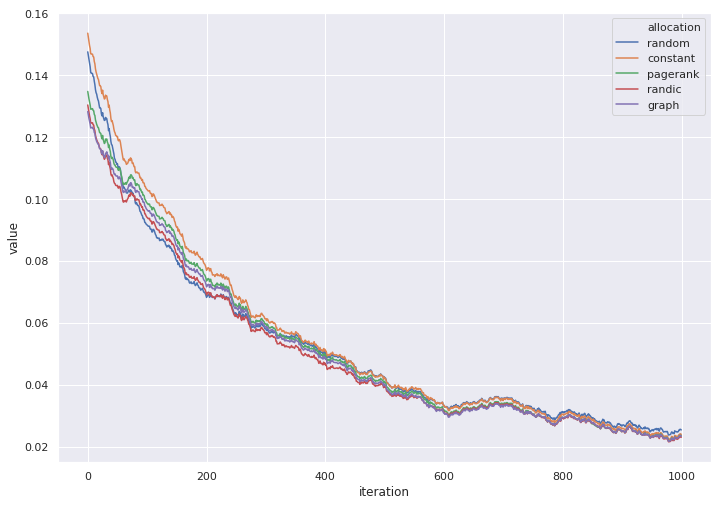

In [375]:
# gini inequality for egocentric networks
distribution_idx = df['inequality level'] == 'egonet distribution'
network_idx = df['network'] == 'brunson_revolution'

sns.lineplot(data=df[distribution_idx & network_idx], x='iteration', y='value', hue='allocation')